In [10]:
from functools import partial
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import pandas as pd
import torch
import numpy as np
from tdigest import TDigest

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl
from importlib import reload
import src.conformal  as cp
import src.temperature as ts
import src.helpers as helpers
reload(helpers)
reload(cp)
reload(ts)
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']


In [11]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

In [12]:
# path_to_experiments = Path('../experiments/')
# path_to_experiments = Path('experiments/')
path_to_experiments = Path('new_experiments/')

In [13]:
# dataset = 'mnist'
# dataset = 'svhn'
# dataset = 'fashion'
# dataset = 'cifar10'
dataset = 'cifar100'
# dataset = 'bloodmnist'
# dataset = 'dermamnist'
# dataset = 'pathmnist'
# dataset = 'tissuemnist'
# dataset = 'fitzpatrick'

experiment_names = ['tct', 'fedavg', 'central', 'tct_iid', 'fedavg_iid']

fst, snd = map(itemgetter, range(2))

if dataset == 'fitzpatrick':
    # model = 'resnet18'
    model = 'efficientnet-b1'
    partition = 'skin_type_partition'
    # partition = 'three_label_partition'
    _val_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'val_df.csv')
    _test_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'test_df.csv')
    df = pd.concat([_val_df, _test_df]).reset_index()
    experiments = {
        'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}_pretrained_{partition}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_pretrained_{partition}'), dataset=dataset),
        'fedprox': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedprox_{model}_pretrained_{partition}'), dataset=dataset),
        'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_pretrained_{partition}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
        'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
    }
    num_classes = 114
    clients_class_map = None
else:
    clients_class_map = helpers.get_client_map(dataset)
    num_classes = sum(map(len, clients_class_map.values()))
    model = 'small_resnet14'
    experiments = {
        'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}'), dataset=dataset),
        'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition'), dataset=dataset),
    }
    partition = None
    
experiments = dict(filter(snd, experiments.items()))

In [14]:
reload(cp)
reload(helpers)
reload(ts)
num_trials = 10

lac_trials = {}
aps_trials = {}
raps_trials = {}
for i in range(num_trials):
    
    # randomly split into calibration and evaluation sets
    trial = helpers.get_new_trial(experiments, fitzpatrick_df=df if dataset == 'fitzpatrick' else None)
    trial_experiments = trial['experiments']
    val_df = trial['val_df']
    test_df = trial['test_df']

    # apply aggregate temperature scaling
    ts.client_temp_scale(
        trial_experiments, clients_class_map, 
        val_df=val_df, test_df=test_df,
        use_three_partition_label=True if partition == 'three_partition_label' else False,
    )
    
    # partition validation data into clients
    if dataset == 'fitzpatrick':
        _partition = 'three_partition_label' if partition == 'three_partition_label' else 'aggregated_fitzpatrick_scale'
        client_index_map = {
            str(part): (val_df[_partition] == part).values for part in sorted(val_df[_partition].unique())
        }
    else:
        client_index_map = {
            k: sum(trial_experiments['tct']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()
        }

    # conformal parameters
    # alphas = np.arange(0.05, 1, 0.05)
    alphas = np.arange(0.10, 1, 0.10)
    alphas = list(map(lambda x: np.round(x, 2), alphas))
    allow_empty_sets = False # set to True for upper marginal bound
    # allow_empty_sets = True

    f = itemgetter('temp_val_scores', 'val_targets', 'temp_test_scores', 'test_targets')
    
    lac_metrics = cp.get_coverage_size_over_alphas(
        *f(trial_experiments['tct']), method='lac', 
        allow_empty_sets=allow_empty_sets, alphas=alphas, 
        decentral=True, client_index_map=client_index_map,
    )
    lac_trials[i] = lac_metrics
    
    aps_metrics = cp.get_coverage_size_over_alphas(
        *f(trial_experiments['tct']), method='aps', 
        allow_empty_sets=allow_empty_sets, alphas=alphas, 
        decentral=True, client_index_map=client_index_map,
    )
    aps_trials[i] = aps_metrics
    
    raps_metrics = cp.get_coverage_size_over_alphas(
        *f(trial_experiments['tct']), method='raps', 
        allow_empty_sets=allow_empty_sets, alphas=alphas, 
        decentral=True, client_index_map=client_index_map,
        k_reg=1, lam_reg=0.0000001,
    )
    raps_trials[i] = raps_metrics
    
    print(f'finished trial={i}')
    

finished trial=0
finished trial=1
finished trial=2
finished trial=3
finished trial=4
finished trial=5
finished trial=6
finished trial=7
finished trial=8
finished trial=9


In [15]:
reload(helpers)
lac_results = helpers.combine_trials(lac_trials)
aps_results = helpers.combine_trials(aps_trials)
raps_results = helpers.combine_trials(raps_trials)

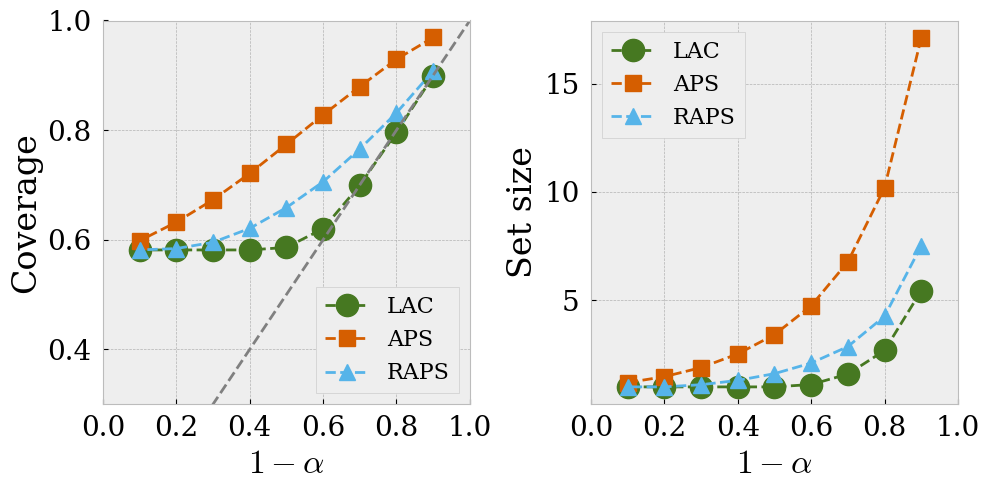

In [16]:
alphas = np.arange(0.10, 1, 0.10)
alphas = list(map(lambda x: np.round(x, 2), alphas))

# plotting settings
fontsize=24
style = '--'
markersize=12

# choose experiments
# exp_1 = central_results['mean']
# exp_2 = naive_central_results['mean']
# exp_3 = None
# exp_1_label = 'Conformal'
# exp_2_label = 'Naive'
# exp_3_label = None

exp_1 = lac_results['mean']
exp_2 = aps_results['mean']
exp_3 = raps_results['mean']
exp_1_label = 'LAC'
exp_2_label = 'APS'
exp_3_label = 'RAPS'


fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
if exp_1 is not None:
    ax[0].plot(*zip(*exp_1['coverage'].items()), style, marker='o', label=exp_1_label, markersize=markersize+4, c='C3')
    ax[1].plot(*zip(*exp_1['size'].items()), style, marker='o', label=exp_1_label, markersize=markersize+4, c='C3')
    
if exp_2 is not None:
    ax[0].plot(*zip(*exp_2['coverage'].items()), style, marker='s', label=exp_2_label, markersize=markersize, c='C4')
    ax[1].plot(*zip(*exp_2['size'].items()), style, marker='s', label=exp_2_label, markersize=markersize, c='C4')

if exp_3 is not None:
    ax[0].plot(*zip(*exp_3['coverage'].items()), style, marker='^', label=exp_3_label, markersize=markersize, c='C6')
    ax[1].plot(*zip(*exp_3['size'].items()), style, marker='^', label=exp_3_label, markersize=markersize, c='C6')

ax[0].plot([0, 1], [0, 1], '--', color='gray')

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)
ax[0].set_ylim(0.3, 1)
# ax[1].set_ylim(0, 20)
# ax[1].set_ylim(-1, 60)
ax[0].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
ax[1].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)
ax[1].set_ylabel('Set size', fontsize=fontsize)
ax[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticks([0.4, 0.6, 0.8, 1])
ax[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# ax[1].set_yticks([1, 2, 3, 4, 5, 6])
ax[0].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[0].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[0].legend(fancybox=False, fontsize=fontsize-8, loc='lower right', framealpha=1.0)
ax[1].legend(fancybox=False, fontsize=fontsize-8, loc='upper left', framealpha=1.0)

plt.tight_layout()
plt.savefig(fig_dir / f'experiment-3-{dataset}-comparing-score.eps', bbox_inches='tight')
# plt.savefig(fig_dir / f'naive-{dataset}.eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


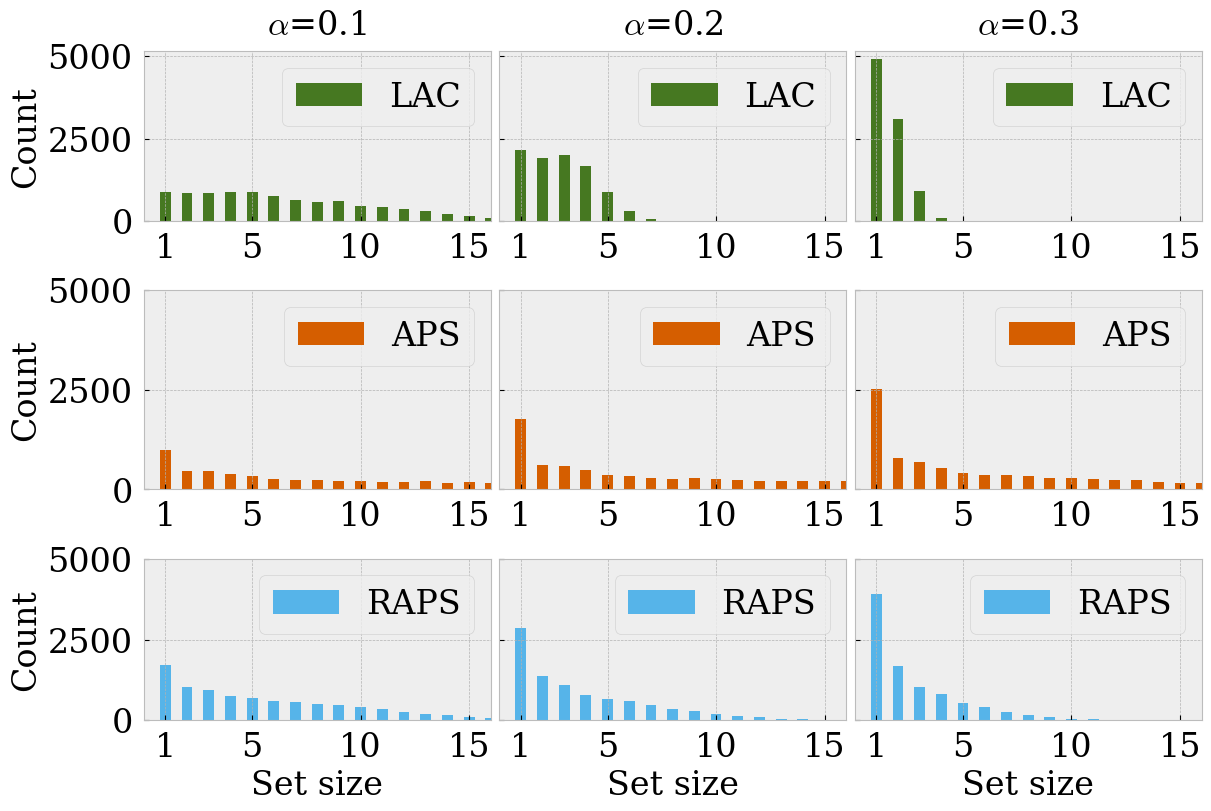

In [17]:
val_logits = experiments['tct']['val_scores']
test_logits = experiments['tct']['test_scores']
val_targets = experiments['tct']['val_targets']
test_targets = experiments['tct']['test_targets']
temp = ts.temp_scale(val_logits, val_targets, plot=False)
val_scores = torch.softmax(val_logits / temp, 1)
test_scores = torch.softmax(test_logits / temp, 1)
                                
fontsize = 24
allow_empty_sets = False 
xlim = 114
# xticks = [1, 25, 50, 75, 100]
xlim = 16
xticks = [1, 5, 10, 15]
yticks = [0, 2500, 5000]
bins=10
                                

fig = plt.figure(constrained_layout=True, figsize=(12, 8))
# fig.suptitle()
subfigs = fig.subfigures(nrows=3)

for col, subfig in enumerate(subfigs):
    if col == 0:
        # subfig.suptitle('LAC', fontsize=fontsize)
        ax = subfig.subplots(ncols=3, sharey=True)
    
        for i, alpha in enumerate((0.1, 0.2, 0.3)):
            lac_q = cp.calibrate_lac(val_scores, val_targets, alpha=alpha)
            lac_psets = cp.inference_lac(test_scores, lac_q, allow_empty_sets=allow_empty_sets)
            lac_size_counts = lac_psets.sum(1).bincount().tolist()
            ax[i].bar(range(len(lac_size_counts)), lac_size_counts, width=0.5, label='LAC', color='C3')
            # ax[i].hist(lac_psets.sum(1), label='LAC', color='C3', bins=len(lac_size_counts) // 2)
            ax[i].set_title(fr'$\alpha$={alpha}', fontsize=fontsize, y=1.05)
            # ax[i].set_xlabel('Set size', fontsize=fontsize)
            if i == 0:
                ax[i].set_ylabel('Count', fontsize=fontsize)
            ax[i].xaxis.set_tick_params(labelsize=fontsize, pad=8)
            ax[i].yaxis.set_tick_params(labelsize=fontsize, pad=8)
            ax[i].set_xticks(xticks)
            ax[i].set_yticks(yticks)
            ax[i].set_xlim(0, xlim)
            # ax[i].set_xlim(0, num_classes)
            ax[i].legend(fontsize=fontsize)
            
    elif col == 1:
        # subfig.suptitle('APS', fontsize=fontsize)
        ax = subfig.subplots(ncols=3, sharey=True)
        for i, alpha in enumerate((0.1, 0.2, 0.3)):
            aps_q = cp.calibrate_aps(val_scores, val_targets, alpha=alpha)
            aps_psets = cp.inference_aps(test_scores, aps_q, allow_empty_sets=allow_empty_sets)
            aps_size_counts = aps_psets.sum(1).bincount().tolist()
            # print(aps_size_counts)
            ax[i].bar(range(len(aps_size_counts)), aps_size_counts, width=0.5, label='APS', color='C4')
            # ax[i].hist(aps_psets.sum(1), label='APS', color='C4', bins=len(aps_size_counts)//2)
            # ax[i].set_title(fr'$\alpha$={alpha}', fontsize=fontsize, y=1.05)
            # ax[i].set_xlabel('Set size', fontsize=fontsize)
            if i == 0:
                ax[i].set_ylabel('Count', fontsize=fontsize)
            ax[i].xaxis.set_tick_params(labelsize=fontsize, pad=8)
            ax[i].yaxis.set_tick_params(labelsize=fontsize, pad=8)
            ax[i].set_xticks(xticks)
            ax[i].set_yticks(yticks)
            ax[i].set_xlim(0, xlim)
            # ax[i].set_xticks([1, 30, 60])
            # ax[i].set_xlim(0, 60)
            # ax[i].set_xlim(0, num_classes)
            ax[i].legend(fontsize=fontsize)
            
    elif col == 2:
        # subfig.suptitle('RAPS', fontsize=fontsize)
        ax = subfig.subplots(ncols=3, sharey=True)
        for i, alpha in enumerate((0.1, 0.2, 0.3)):
            raps_q = cp.calibrate_raps(val_scores, val_targets, alpha=alpha, k_reg=1, lam_reg=0.001)
            raps_psets = cp.inference_raps(test_scores, raps_q, allow_empty_sets=allow_empty_sets, k_reg=1, lam_reg=0.01)
            raps_size_counts = raps_psets.sum(1).bincount().tolist()
            ax[i].bar(range(len(raps_size_counts)), raps_size_counts, width=0.5, label='RAPS', color='C6')
            # ax[i].hist(raps_psets.sum(1), label='RAPS', color='C6', bins=len(raps_size_counts)//2)
            # ax[i].set_title(fr'$\alpha$={alpha}', fontsize=fontsize, y=1.05)
            ax[i].set_xlabel('Set size', fontsize=fontsize)
            if i == 0:
                ax[i].set_ylabel('Count', fontsize=fontsize)
            ax[i].xaxis.set_tick_params(labelsize=fontsize, pad=8)
            ax[i].yaxis.set_tick_params(labelsize=fontsize, pad=8)
            ax[i].set_xticks(xticks)
            ax[i].set_yticks(yticks)
            ax[i].set_xlim(0, xlim)
            # ax[i].set_xlim(0, num_classes)
            ax[i].legend(fontsize=fontsize)
            
plt.savefig(fig_dir / f'{dataset}-score_dist.eps', bbox_inches='tight')
plt.show()

In [18]:
print("LAC")
print(f"{lac_results['mean']['q1_coverage'][0.9]:.2f}", f"{lac_results['std']['q1_coverage'][0.9]:.2f}")
print(f"{lac_results['mean']['q2_coverage'][0.9]:.2f}", f"{lac_results['std']['q2_coverage'][0.9]:.2f}")
print(f"{lac_results['mean']['q3_coverage'][0.9]:.2f}", f"{lac_results['std']['q3_coverage'][0.9]:.2f}")
print(f"{lac_results['mean']['q4_coverage'][0.9]:.2f}", f"{lac_results['std']['q4_coverage'][0.9]:.2f}")
print()
print(f"{lac_results['mean']['q1_size'][0.9]:.2f}", f"{lac_results['std']['q1_size'][0.9]:.2f}")
print(f"{lac_results['mean']['q2_size'][0.9]:.2f}", f"{lac_results['std']['q2_size'][0.9]:.2f}")
print(f"{lac_results['mean']['q3_size'][0.9]:.2f}", f"{lac_results['std']['q3_size'][0.9]:.2f}")
print(f"{lac_results['mean']['q4_size'][0.9]:.2f}", f"{lac_results['std']['q4_size'][0.9]:.2f}")

print()
print()
print("APS")
print(f"{aps_results['mean']['q1_coverage'][0.9]:.2f}", f"{aps_results['std']['q1_coverage'][0.9]:.2f}")
print(f"{aps_results['mean']['q2_coverage'][0.9]:.2f}", f"{aps_results['std']['q2_coverage'][0.9]:.2f}")
print(f"{aps_results['mean']['q3_coverage'][0.9]:.2f}", f"{aps_results['std']['q3_coverage'][0.9]:.2f}")
print(f"{aps_results['mean']['q4_coverage'][0.9]:.2f}", f"{aps_results['std']['q4_coverage'][0.9]:.2f}")
print()
print(f"{aps_results['mean']['q1_size'][0.9]:.2f}", f"{aps_results['std']['q1_size'][0.9]:.2f}")
print(f"{aps_results['mean']['q2_size'][0.9]:.2f}", f"{aps_results['std']['q2_size'][0.9]:.2f}")
print(f"{aps_results['mean']['q3_size'][0.9]:.2f}", f"{aps_results['std']['q3_size'][0.9]:.2f}")
print(f"{aps_results['mean']['q4_size'][0.9]:.2f}", f"{aps_results['std']['q4_size'][0.9]:.2f}")

print()
print()
print("RAPS")
print(f"{raps_results['mean']['q1_coverage'][0.9]:.2f}", f"{raps_results['std']['q1_coverage'][0.9]:.2f}")
print(f"{raps_results['mean']['q2_coverage'][0.9]:.2f}", f"{raps_results['std']['q2_coverage'][0.9]:.2f}")
print(f"{raps_results['mean']['q3_coverage'][0.9]:.2f}", f"{raps_results['std']['q3_coverage'][0.9]:.2f}")
print(f"{raps_results['mean']['q4_coverage'][0.9]:.2f}", f"{raps_results['std']['q4_coverage'][0.9]:.2f}")
print()
print(f"{raps_results['mean']['q1_size'][0.9]:.2f}", f"{raps_results['std']['q1_size'][0.9]:.2f}")
print(f"{raps_results['mean']['q2_size'][0.9]:.2f}", f"{raps_results['std']['q2_size'][0.9]:.2f}")
print(f"{raps_results['mean']['q3_size'][0.9]:.2f}", f"{raps_results['std']['q3_size'][0.9]:.2f}")
print(f"{raps_results['mean']['q4_size'][0.9]:.2f}", f"{raps_results['std']['q4_size'][0.9]:.2f}")


LAC
0.97 0.01
0.93 0.01
0.85 0.01
0.81 0.01

1.94 0.05
4.50 0.00
6.83 0.17
10.64 0.37


APS
0.96 0.00
0.97 0.00
0.97 0.00
0.97 0.00

2.10 0.00
8.63 0.22
20.33 0.52
39.24 0.80


RAPS
0.94 0.01
0.92 0.01
0.88 0.01
0.88 0.01

1.30 0.00
3.78 0.13
8.27 0.29
18.70 0.47


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


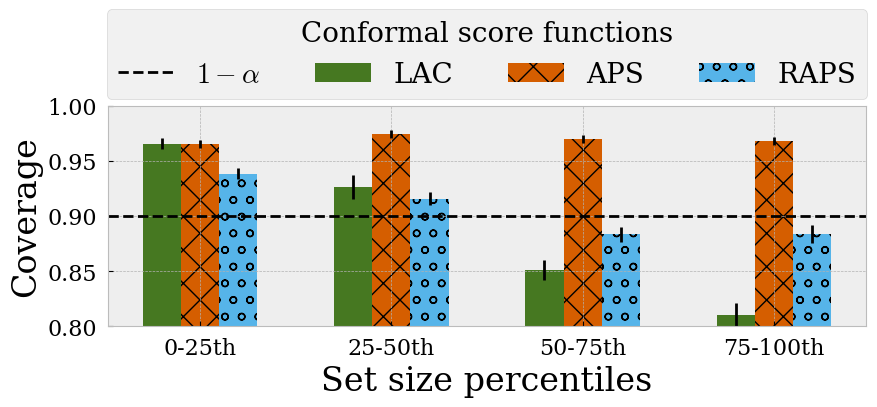

In [163]:
lac_coverage_mean = [
    lac_results['mean']['q1_coverage'][0.9],
    lac_results['mean']['q2_coverage'][0.9],
    lac_results['mean']['q3_coverage'][0.9],
    lac_results['mean']['q4_coverage'][0.9],
]
aps_coverage_mean = [
    aps_results['mean']['q1_coverage'][0.9],
    aps_results['mean']['q2_coverage'][0.9],
    aps_results['mean']['q3_coverage'][0.9],
    aps_results['mean']['q4_coverage'][0.9],
]
raps_coverage_mean = [
    raps_results['mean']['q1_coverage'][0.9],
    raps_results['mean']['q2_coverage'][0.9],
    raps_results['mean']['q3_coverage'][0.9],
    raps_results['mean']['q4_coverage'][0.9],
]
lac_coverage_std = [
    lac_results['std']['q1_coverage'][0.9],
    lac_results['std']['q2_coverage'][0.9],
    lac_results['std']['q3_coverage'][0.9],
    lac_results['std']['q4_coverage'][0.9],
]
aps_coverage_std = [
    aps_results['std']['q1_coverage'][0.9],
    aps_results['std']['q2_coverage'][0.9],
    aps_results['std']['q3_coverage'][0.9],
    aps_results['std']['q4_coverage'][0.9],
]
raps_coverage_std = [
    raps_results['std']['q1_coverage'][0.9],
    raps_results['std']['q2_coverage'][0.9],
    raps_results['std']['q3_coverage'][0.9],
    raps_results['std']['q4_coverage'][0.9],
]
width=0.20
offset = 0.2
label_type = 'edge'
fontsize=24

fig, ax = plt.subplots(figsize=(9, 5))
lac_rects = ax.bar(np.arange(4)-offset, lac_coverage_mean, yerr=lac_coverage_std, width=width, label='LAC', color='C3')
aps_rects = ax.bar(np.arange(4), aps_coverage_mean, yerr=aps_coverage_std, width=width, label='APS', color='C4', hatch='x')
raps_rects = ax.bar(np.arange(4)+offset, raps_coverage_mean, yerr=raps_coverage_std, width=width, label='RAPS', color='C6', hatch='o')

ax.axhline(0.9, color='k', ls='--', label=r'$1-\alpha$')
# ax.bar_label(lac_rects, padding=3, fmt='%.2f', label_type=label_type)
# ax.bar_label(aps_rects, padding=3, fmt='%.2f', label_type=label_type)
# ax.bar_label(raps_rects, padding=3, fmt='%.2f', label_type=label_type)
ax.set_xlabel('Set size percentiles', fontsize=fontsize)
ax.set_ylabel('Coverage', fontsize=fontsize)
# ax.set_title('Scores by group and gender')
ax.set_xticks(range(4), ['0-25th', '25-50th', '50-75th', '75-100th'], fontsize=fontsize-6)
ax.xaxis.set_tick_params(labelsize=fontsize-8, pad=8)
ax.yaxis.set_tick_params(labelsize=fontsize-8, pad=8)
ax.legend(ncol=4, fontsize=fontsize-4, 
          title='Conformal score functions', title_fontsize=fontsize-4, 
          bbox_to_anchor=(0, 0, 1.02, 1.50), fancybox = True, #shadow = True,
         )
plt.ylim(0.80, 1.00)

plt.tight_layout()
plt.savefig(fig_dir / f'experiment-3-{dataset}-comparing-score-conditional-coverage.eps', bbox_inches='tight')
plt.show()

In [ ]:
plt.bar(yerr)

In [19]:
raps_results['mean']['q1_coverage'][0.9]

0.9384269714355469